In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ner-dataset/ner_dataset.csv


For running and training model, please find at https://www.kaggle.com/trangdothuy/crf-for-ner

In [2]:
! pip install plot_keras_history

  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.30-py3-none-any.whl size=8793 sha256=95cd99ae22390ad38adfe920cb37cb4395c1d7b889ab1fa61e38032cc6bf94ca
  Stored in directory: /root/.cache/pip/wheels/b0/60/47/8c5aa37c06be5e97879ec467bc2e6a30b315d95f662c63a503
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.29-py3-none-any.whl size=7877 sha256=b349fd4c401f46002797c8cc58f75887625cd62533e9385df65cf4bc2e121c72
  Stored in directory: /root/.cache/pip/wheels/c2/f5/71/d1c459da10abec864a1979b449edbf37d4a82ab3e38a3625a8
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4585 sha256=ce1819a5f2c5cb5718c86273d89037b7598e816fdd38dcb903f917ad3d6acc30
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-his

In [3]:
import pickle
import operator
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from plot_keras_history import plot_history
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

import tensorflow as tf 
from tensorflow import keras

from keras import layers
from keras import optimizers

from keras.models import Model
from keras.models import Input

from tensorflow_addons.layers import CRF

from tensorflow.keras.optimizers import Adam


In [4]:
DENSE_EMBEDDING = 50
LSTM_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_UNITS = 100
BATCH_SIZE = 256
MAX_EPOCHS = 5

MAX_SENTENCE = 128

data_df = pd.read_csv("../input/ner-dataset/ner_dataset.csv", encoding="iso-8859-1", header=0)
data_df = data_df.fillna(method="ffill")
data_df["Sentence #"] = data_df["Sentence #"].apply(lambda s: s[9:])
data_df["Sentence #"] = data_df["Sentence #"].astype("int32")

print("Total number of sentences in the dataset: {:,}".format(data_df["Sentence #"].nunique()))
print("Total words in the dataset: {:,}".format(data_df.shape[0]))


Total number of sentences in the dataset: 47,959
Total words in the dataset: 1,048,575


In [5]:
all_words = list(set(data_df["Word"].values))
all_tags = list(set(data_df["Tag"].values))

word2index = {word: idx + 2 for idx, word in enumerate(all_words)}
word2index["--UNKNOWN_WORD--"]=0
word2index["--PADDING--"]=1

index2word = {idx: word for word, idx in word2index.items()}
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["--PADDING--"] = 0
index2tag = {idx: word for word, idx in tag2index.items()}

WORD_COUNT = len(index2word)

def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

sentences = data_df.groupby("Sentence #").apply(to_tuples).tolist()

In [6]:
X = []
for sentence in sentences:
    text = []
    for word in sentence:
        text.append(word[0])
    padded_text = text + ["--PADDING--"] * (MAX_SENTENCE - len(text))
    X.append(padded_text)

y = []
for sentence in sentences:
    tags = []
    for word in sentence:
        tags.append(word[2])
    padded_tags = tags + ["--PADDING--"] * (MAX_SENTENCE - len(tags))
    y.append(padded_tags)
    

X = np.array([np.array([word2index[word] for word in sentence]) for sentence in X])
y = np.array([np.array([tag2index[tag] for tag in sentence]) for sentence in y])


TAG_COUNT = len(tag2index)
y = [ np.eye(TAG_COUNT)[sentence] for sentence in y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
y_train = np.stack(y_train)
y_test = np.stack(y_test)

In [7]:
input_layer = layers.Input(shape=(MAX_SENTENCE,))

model = layers.Embedding(WORD_COUNT, DENSE_EMBEDDING, embeddings_initializer="uniform", input_length=MAX_SENTENCE)(input_layer)

model = layers.Bidirectional(layers.LSTM(LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(model)

model = layers.TimeDistributed(layers.Dense(DENSE_UNITS, activation="relu"))(model)

crf_layer = CRF(units=TAG_COUNT)
_, output_layer, _, _  = crf_layer(model)

ner_model = Model(input_layer, output_layer)

ner_model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

ner_model.summary()

2021-12-23 03:27:11.128358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 03:27:11.222732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 03:27:11.223774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 03:27:11.225354: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 50)           1759000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 100)          40400     
_________________________________________________________________
time_distributed (TimeDistri (None, 128, 100)          10100     
_________________________________________________________________
crf (CRF)                    [(None, 128), (None, 128, 2178      
Total params: 1,811,678
Trainable params: 1,811,678
Non-trainable params: 0
_________________________________________________________________


2021-12-23 03:27:16.802244: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
152/152 [==============================] - 217s 1s/step - loss: 14.6939 - accuracy: 0.1435 - val_loss: 14.8854 - val_accuracy: 0.1441
Epoch 2/5
152/152 [==============================] - 212s 1s/step - loss: 14.7843 - accuracy: 0.1447 - val_loss: 14.9816 - val_accuracy: 0.1441
Epoch 3/5
152/152 [==============================] - 211s 1s/step - loss: 14.5236 - accuracy: 0.1447 - val_loss: 14.5805 - val_accuracy: 0.1441
Epoch 4/5
152/152 [==============================] - 210s 1s/step - loss: 14.5124 - accuracy: 0.1447 - val_loss: 14.4807 - val_accuracy: 0.1441
Epoch 5/5
152/152 [==============================] - 212s 1s/step - loss: nan - accuracy: 0.1930 - val_loss: nan - val_accuracy: 0.8298


/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: CRF decoding models have serialization issues in TF >=2.5 . Please see isse #2476
  return py_builtins.overload_of(f)(*args)


Accuracy: 0.8287/


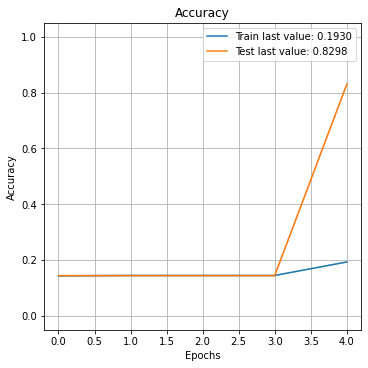

In [8]:
history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_split=0.1)

plot_history(history.history)

y_pred = ner_model.predict(X_test)

y_pred = np.argmax(y_pred, axis=2)

y_test = np.argmax(y_test, axis=2)

accuracy = (y_pred == y_test).mean()

print("Accuracy: {:.4f}/".format(accuracy))

In [9]:
def tag_conf_matrix(cm, tagid):
    tag_name = index2tag[tagid]
    print("Tag name: {}".format(tag_name))
    print(cm[tagid])
    tn, fp, fn, tp = cm[tagid].ravel()
    tag_acc = (tp + tn) / (tn + fp + fn + tp)
    print("Tag accuracy: {:.3f} \n".format(tag_acc))

matrix = multilabel_confusion_matrix(y_test.flatten(), y_pred.flatten())

tag_conf_matrix(matrix, 8)
tag_conf_matrix(matrix, 14)

sentence = "President Obama became the first sitting American president to visit Hiroshima"

re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
sentence = re_tok.sub(r"  ", sentence).split()

padded_sentence = sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence))
padded_sentence = [word2index.get(w, 0) for w in padded_sentence]

pred = ner_model.predict(np.array([padded_sentence]))
pred = np.argmax(pred, axis=-1)

retval = ""
for w, p in zip(sentence, pred[0]):
    retval = retval + "{:15}: {:5}".format(w, index2tag[p]) + "\n"
print(retval)

Tag name: I-art
[[613854      0]
 [    34      0]]
Tag accuracy: 1.000 

Tag name: B-per
[[612263      0]
 [  1625      0]]
Tag accuracy: 0.997 

President      : --PADDING--
Obama          : --PADDING--
became         : --PADDING--
the            : --PADDING--
first          : --PADDING--
sitting        : --PADDING--
American       : --PADDING--
president      : --PADDING--
to             : --PADDING--
visit          : --PADDING--
Hiroshima      : --PADDING--

